# Import libs

In [49]:
import numpy as np
import pandas as pd

In [50]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from ucimlrepo import fetch_ucirepo 
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [52]:
import neural_lib as nl

In [53]:
# fetch dataset 
zoo = fetch_ucirepo(id=111) 

# data (as pandas dataframes) 
feature = zoo.data.features 
target = zoo.data.targets 
zoo = pd.concat([feature, target], axis=1)
zoo

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


# Step 0. Binarize the data

In [54]:
# Perform one-hot encoding 
y = pd.get_dummies(target, columns=['type'], prefix=['class'])
X = pd.get_dummies(feature, columns=['legs'], prefix=['legs'])

#convert the binary numerical value to bool
y.replace({0: False, 1: True}, inplace=True)
X.replace({0: False, 1: True}, inplace=True)
y.index = X.index.astype(str)
X.index = X.index.astype(str)

# delete catsize, because i will deal just with the targte class_2, which represent birds, and there is no need to the additional attributes for animals with 4, 5, 6 and 8 legs, i put just with 0 and 2 legs 
X.drop(['catsize','legs_5','legs_6','legs_8'], axis=1, inplace=True)

X= X.rename_axis("Object")
y= y.rename_axis("Object")

# take just one class in the target varible(class_2 = 'birds'), to avoid multilabel-indicator
y_one_target = y['class_2'].copy()
X

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,legs_0,legs_2,legs_4
Object,,,,,,,,,,,,,,,,,
0,True,False,False,True,False,False,True,True,True,True,False,False,False,False,False,False,True
1,True,False,False,True,False,False,False,True,True,True,False,False,True,False,False,False,True
2,False,False,True,False,False,True,True,True,True,False,False,True,True,False,True,False,False
3,True,False,False,True,False,False,True,True,True,True,False,False,False,False,False,False,True
4,True,False,False,True,False,False,True,True,True,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,True,False,False,True,False,False,False,True,True,True,False,False,True,False,False,True,False
97,True,False,True,False,True,False,False,False,False,True,True,False,False,False,False,False,False
98,True,False,False,True,False,False,True,True,True,True,False,False,True,False,False,False,True


Split the data to train and test

In [55]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_target, test_size=0.2, random_state=42)

## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [56]:
K_train = FormalContext.from_pandas(X_train)

K_train

FormalContext (80 objects, 17 attributes, 551 connections)
  |hair|feathers|eggs|milk|airborne|...|tail|domestic|legs_0|legs_2|legs_4|
89|    |        |   X|    |        |...|    |        |      |      |     X|
26|    |        |   X|    |        |...|    |        |      |      |     X|
42|    |        |   X|    |       X|...|    |        |      |      |      |
70|   X|        |    |   X|        |...|   X|       X|      |      |     X|
15|    |        |   X|    |        |...|    |        |      |      |      |
40|   X|        |   X|    |       X|...|    |        |      |      |      |
72|    |        |    |    |        |...|   X|        |      |      |      |
9 |   X|        |    |   X|        |...|    |       X|      |      |     X|
96|   X|        |    |   X|        |...|   X|        |      |     X|      |
11|    |       X|   X|    |       X|...|   X|       X|      |     X|      |
...........................................................................
.............................

In [57]:
L = ConceptLattice.from_context(K_train, algo='Sofia', is_monotone=True)
len(L)

49

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [58]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [59]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:21])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [60]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [61]:
vis = LineVizNx(node_label_font_size=15, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n\n')

Move the nodes in visualization to make it look pretty

#### various techniques to select best features from the concept lattice:

In [62]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_features = SelectKBest(chi2)
x_kbest_features = chi2_features.fit_transform(X_train, y_train)
x_kbest_features_int = x_kbest_features.astype(int)
x_kbest_features.shape

(80, 10)

In [63]:
# Get the selected feature indices
selected_feature_indices = chi2_features.get_support(indices=True)

# Get the names of the selected columns
selected_column_names = X_train.columns[selected_feature_indices]
for i in range(len(selected_column_names)):
    print(" feature with column_index {:} = {:}".format(selected_feature_indices[i], selected_column_names[i]))

 feature with column_index 0 = hair
 feature with column_index 1 = feathers
 feature with column_index 2 = eggs
 feature with column_index 3 = milk
 feature with column_index 4 = airborne
 feature with column_index 7 = toothed
 feature with column_index 11 = fins
 feature with column_index 14 = legs_0
 feature with column_index 15 = legs_2
 feature with column_index 16 = legs_4


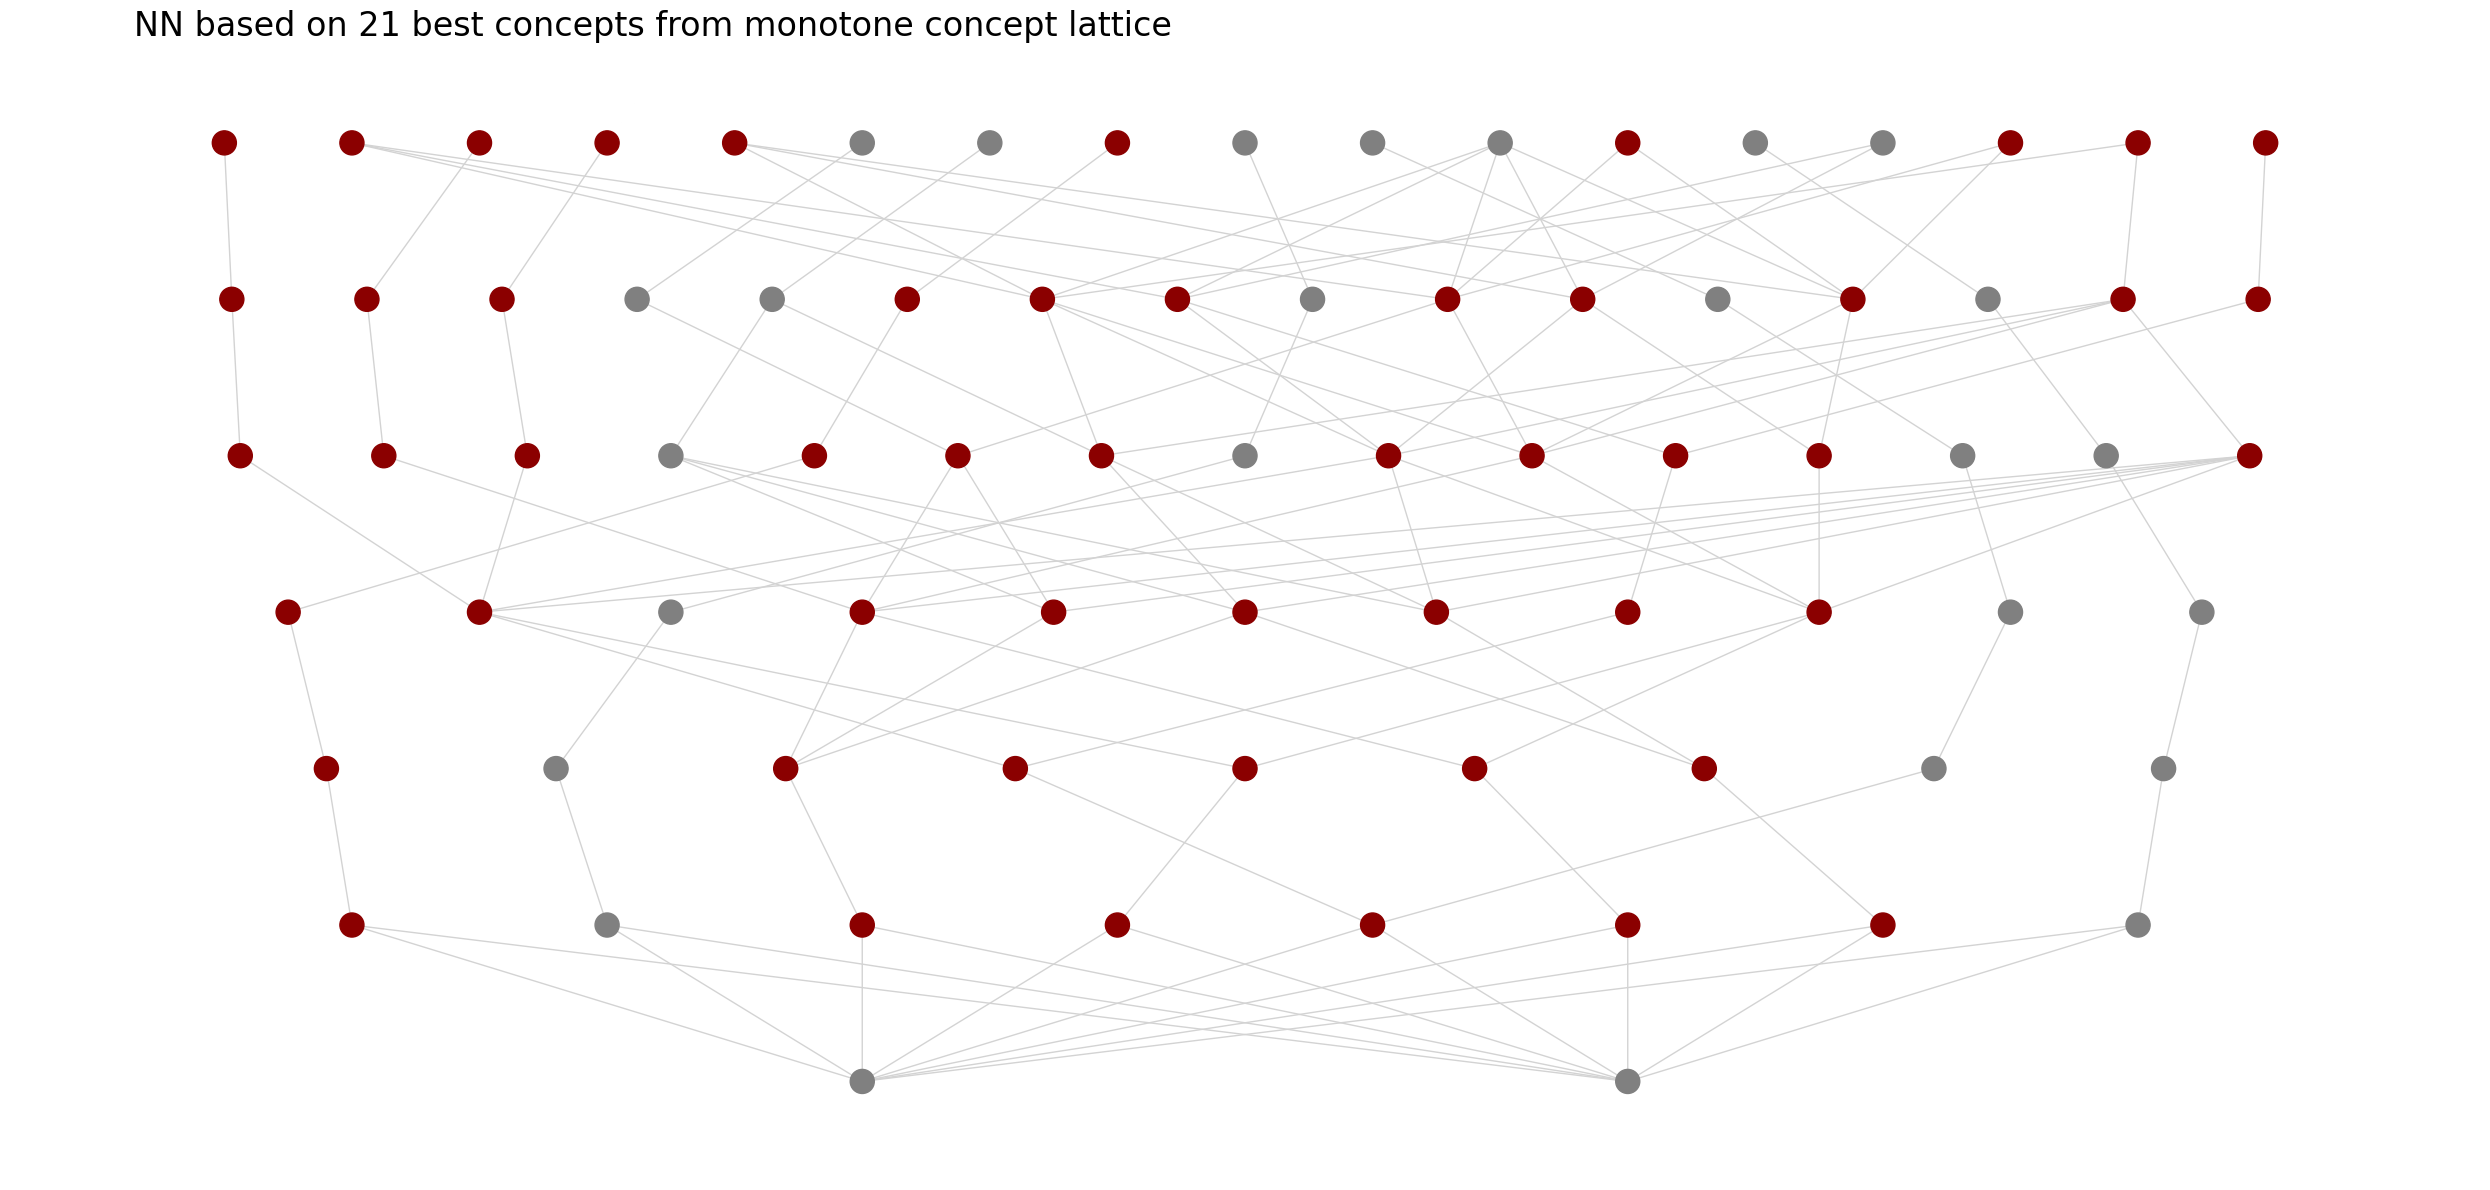

('hair',
 'feathers',
 'eggs',
 'milk',
 'airborne',
 'aquatic',
 'predator',
 'toothed',
 'backbone',
 'breathes',
 'venomous',
 'fins',
 'tail',
 'domestic',
 'legs_0',
 'legs_2',
 'legs_4')

In [64]:
# Create a new ConceptNetwork with feature attributes
cn_with_features = nl.ConceptNetwork(poset=cn.poset, attributes=selected_column_names)

# Visualize the ConceptNetwork with selected features
vis = LineVizNx(node_label_font_size=0, node_label_func=lambda el_i, P: '', flg_node_indices=False)

selected_column_names_class = set(selected_column_names)
traced = cn_with_features.trace_description(selected_column_names_class , include_targets=False)

fig, ax = plt.subplots(figsize=(25, 12))
vis.draw_poset(
    cn_with_features.poset, ax=ax,
    flg_node_indices=False,
    flg_node_labels=False,
    node_color=['darkred' if el_i in traced else 'gray' for el_i in range(len(cn_with_features.poset))]
)

plt.title(f'NN based on 21 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)
plt.subplots_adjust()
plt.tight_layout()
plt.show()
cn.attributes
#concerning the last level(target value), the left one is "False", and the right one is "True" 

In [65]:
cn.fit(X_train, y_train)

In [66]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
Class prediction with probabilities [[9.99910593e-01 8.93679971e-05]
 [9.99910593e-01 8.93679971e-05]
 [1.00000000e+00 2.01976378e-14]
 [9.99910593e-01 8.93679971e-05]
 [9.99910593e-01 8.93679971e-05]
 [1.00000000e+00 7.50379403e-09]
 [9.99910593e-01 8.93679971e-05]
 [9.99910593e-01 8.93679971e-05]
 [9.99910593e-01 8.93679971e-05]
 [9.99910593e-01 8.93679971e-05]
 [1.00000000e+00 1.12721295e-13]
 [9.99501467e-01 4.98548965e-04]
 [1.00000000e+00 7.50379403e-09]
 [1.39756855e-02 9.86024320e-01]
 [1.00000000e+00 2.76899163e-13]
 [9.99910593e-01 8.93679971e-05]
 [9.99910593e-01 8.93679971e-05]
 [1.39756855e-02 9.86024320e-01]
 [1.00000000e+00 1.12721295e-13]
 [9.99910593e-01 8.93679971e-05]
 [1.00000000e+00 4.96154665e-14]]
True class [False False False False False False False False False False False False
 False  True False False False  True False False False]


In [67]:
edge_weights = cn.edge_weights_from_network()

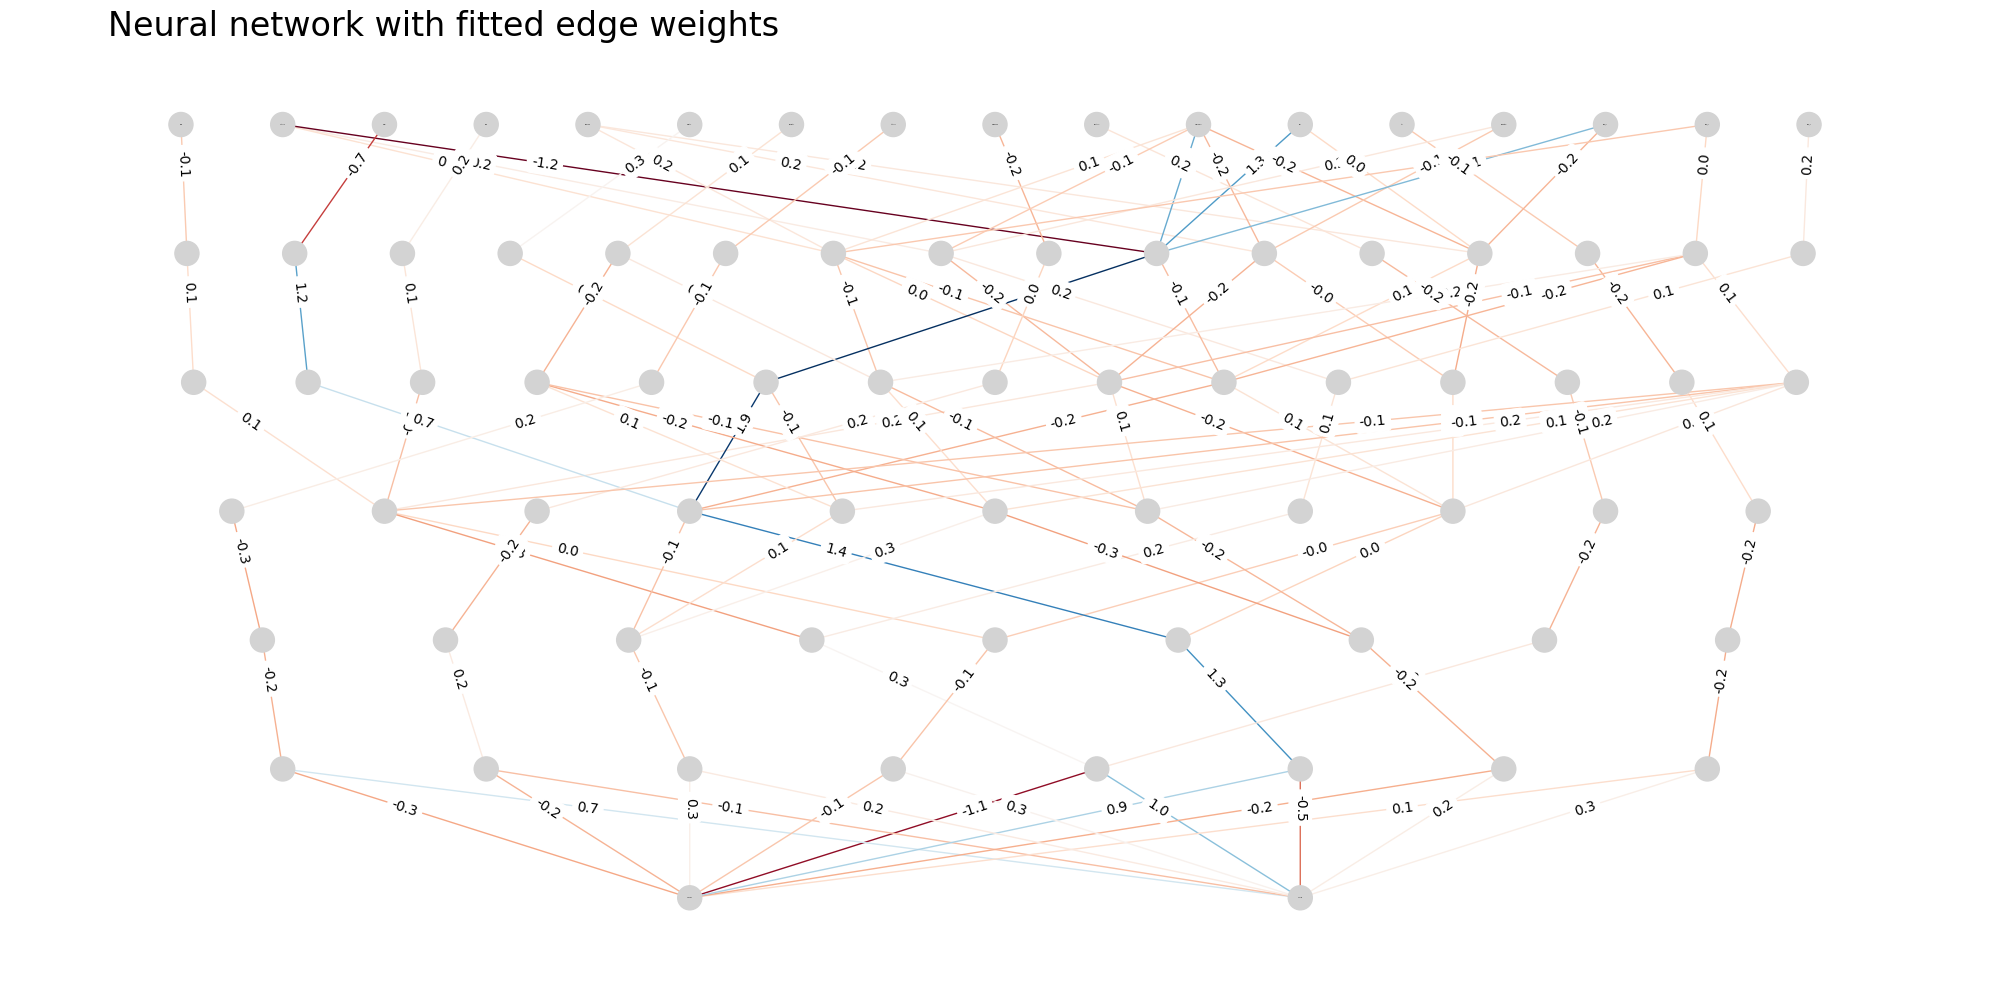

In [68]:
import networkx as nx

fig, ax = plt.subplots(figsize=(20,10))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [69]:
final_y_test_str = y_test.astype(str)

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=0),
    'Logistic Regression': LogisticRegression(random_state=42, multi_class='ovr', max_iter=10000)
}

# Initialize empty dictionaries to store results
accuracies = {}
f1_scores = {}

# Perform cross-validation and parameter tuning for each classifier
for name, clf in classifiers.items():
    print(f"Training {name} Classifier...")
    
    if name == 'Decision Tree':
        # Define the parameter grid for Decision Tree
        param_grid = {
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif name == 'Random Forest':
        # Define the parameter grid for Random Forest
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif name == 'k-NN':
        # Define the parameter grid for k-NN
        param_grid = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    else:
        param_grid = {}  # No parameter tuning for other classifiers
    
    # Create GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Train the classifier using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and estimator from GridSearchCV
    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_
    
    # Make predictions using the best classifier
    y_pred = best_clf.predict(X_test)
    y_pred_str = y_pred.astype(str)
    
    # Calculate accuracy and F1-score
    accuracy = accuracy_score(final_y_test_str, y_pred_str)
    f1 = f1_score(final_y_test_str, y_pred_str, average='weighted', zero_division=1)
    
    # Store results in dictionaries
    accuracies[name] = accuracy
    f1_scores[name] = f1
    
    # Display the results for the current classifier
    print(f"{name} Classifier:")
    print("Best Parameters:")
    print(best_params)
    print(f"Accuracy: {accuracy:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print("Classification Report:")
    print(classification_report(final_y_test_str, y_pred_str))
    print("-" * 40)

# Display the overall performance of all classifiers
print("Overall Performance:")
for name in classifiers.keys():
    print(f"{name} - Accuracy: {accuracies[name]:.4f}, F1 Score: {f1_scores[name]:.4f}")


Training Decision Tree Classifier...
Decision Tree Classifier:
Best Parameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 1.000000
F1 Score: 1.000000
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        19
        True       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

----------------------------------------
Training Random Forest Classifier...
Random Forest Classifier:
Best Parameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 1.000000
F1 Score: 1.000000
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        19
        True       1.00      1.00      1.00         2

    accuracy                          

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan  1. nan  1. nan  1.]
  warnings.warn(


k-NN Classifier:
Best Parameters:
{'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 1.000000
F1 Score: 1.000000
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        19
        True       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

----------------------------------------
Training CatBoost Classifier...
CatBoost Classifier:
Best Parameters:
{}
Accuracy: 1.000000
F1 Score: 1.000000
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        19
        True       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

----------------------------------

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


In [70]:
# Initialize the XGBoost classifier 
xgb_classifier = XGBClassifier(
    random_state=42,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3
)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print("Accuracy:", accuracy)
print("f1-score:", f1)
print("Classification Report:")
print(classification_rep)

Accuracy: 1.0
f1-score: 1.0
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        19
        True       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [71]:
# Display the overall performance of all classifiers
print("Overall Performance:\n")
for name in classifiers.keys():
    print(f"{name} - Accuracy: {accuracies[name]:.4f}, F1 Score: {f1_scores[name]:.4f}")
    print("-" * 50)
    
print(f"XGBoost - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print("-" * 50)

accuracy_FCA = accuracy_score( y_test.values, cn.predict(X_test).numpy())
f1_FCA = f1_score( y_test.values, cn.predict(X_test).numpy(), average='weighted', zero_division=1)
print(f"Neural_FCA - Accuracy: {accuracy_FCA:.4f}, F1 Score: {f1_FCA:.4f}")

Overall Performance:

Decision Tree - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
Random Forest - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
Naive Bayes - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
k-NN - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
CatBoost - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
Logistic Regression - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
XGBoost - Accuracy: 1.0000, F1 Score: 1.0000
--------------------------------------------------
Neural_FCA - Accuracy: 1.0000, F1 Score: 1.0000
